In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import keras

import json
import os

import sys
sys.path.insert(0, '../../../')

import ml

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping


dtypes = ['train', 'validate', 'test']

%load_ext autoreload
%autoreload 2

# Physics-aware network training

We train physics-aware networks in this notebook. We also save the trained model's weights and predictions. Additional predictions are made on mirror circuits, if a mirror circuit dataset exists.

Set the experiment number.

In [2]:
exp_num = 4

Set up file paths and create the folders in which the model weights and predictions will be kept.

In [3]:
alphas = {'train': 1, 'validate': .75, 'test': .4}

exp_path = f'./experiment_{exp_num}/'
sim_path = exp_path + '/simulation_results/'
proc_path = exp_path + '/processed_inputs_and_outputs/'

model_path = exp_path + '/models/'
history_path = exp_path + '/training_histories/'
pred_path = exp_path + '/predictions/'

os.makedirs(model_path, exist_ok = True)
os.makedirs(history_path, exist_ok = True)
os.makedirs(pred_path, exist_ok = True)

Load up the circuits and the (scaled) infidelities.

In [4]:
circuits = np.load(proc_path+'/processed_high_fidelity_circuits.npz')
infidelities = np.load(proc_path+'/processed_infidelities.npz')

Load up the necessary meta information, and create some necessary model parameters (e.g., the list of tracked errors).

In [5]:
with open(exp_path+'/meta.json', 'r') as f:
    meta = json.load(f)

num_qubits = meta['num_qubits']
max_error_weight = meta['max_error_weight']
num_hops = meta['num_hops']
num_channels = meta['num_channels']
if meta['geometry'] == 'ring':
    adj_matrix = ml.newtools.ring_adj_matrix(num_qubits)
    laplace = ml.newtools.laplace_from_qubit_graph(adj_matrix)
else:
    print(f'You have not implemented the {geometry} geometry.')

error_gens = ml.newtools.up_to_weight_k_error_gens_from_qubit_graph(max_error_weight, num_qubits, laplace, num_hops)

Quick visual verification that you have a good distribution of infidelities.

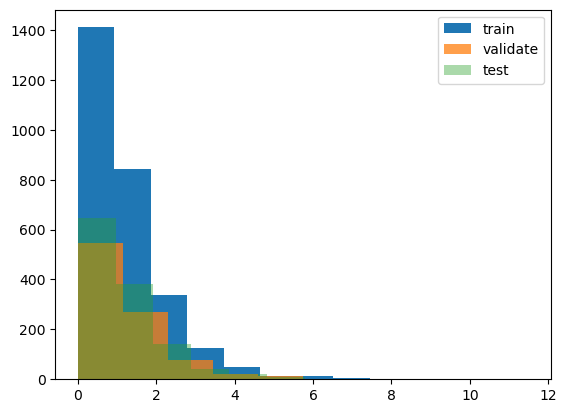

In [6]:
fig, ax = plt.subplots()
for dt in dtypes:
    ax.hist(infidelities[dt] / 100, label = dt, alpha = alphas[dt])
ax.legend()

In [7]:
len(infidelities['train'])+len(infidelities['validate'])+len(infidelities['test'])

4985

# Create  and train the network

The next cell instantiates the model (`CircuitErrorVec`) and trains the model using the Adam optimizer and MSE as the loss function. We use early stopping to cut the model training short when the model's validation loss plateaus.

In [8]:
from keras.callbacks import EarlyStopping

layer_snipper = ml.newneuralnets.layer_snipper_from_qubit_graph
layer_snipper_args = [num_qubits, num_channels, laplace, num_hops]

optimizer = keras.optimizers.Adam(learning_rate=1e-3)

circuit_dense = ml.newneuralnets.CircuitErrorVec(num_qubits, num_channels, error_gens, layer_snipper,
                                                layer_snipper_args)

circuit_dense.compile(optimizer, loss=keras.losses.MeanSquaredError())

callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 50)

history1 = circuit_dense.fit(circuits['train'], infidelities['train'], epochs=200, batch_size=32, 
                             validation_data=[circuits['validate'], infidelities['validate']], callbacks = [callback])

Epoch 1/200
88/88 [==============================] - 185s 743ms/step - loss: 13283.9688 - val_loss: 7331.5669
Epoch 2/200
88/88 [==============================] - 54s 618ms/step - loss: 5465.7305 - val_loss: 6721.7227
Epoch 3/200
88/88 [==============================] - 52s 594ms/step - loss: 5213.3467 - val_loss: 6535.8374
Epoch 4/200
88/88 [==============================] - 53s 603ms/step - loss: 5039.8135 - val_loss: 6392.6055
Epoch 5/200
88/88 [==============================] - 57s 646ms/step - loss: 5036.8828 - val_loss: 6452.4775
Epoch 6/200
88/88 [==============================] - 53s 606ms/step - loss: 4968.7144 - val_loss: 6506.0825
Epoch 7/200
88/88 [==============================] - 53s 604ms/step - loss: 4903.1870 - val_loss: 6178.8188
Epoch 8/200
88/88 [==============================] - 53s 601ms/step - loss: 4910.9546 - val_loss: 6288.7627
Epoch 9/200
88/88 [==============================] - 53s 604ms/step - loss: 4886.1577 - val_loss: 6379.4390
Epoch 10/200
88/88 [======

Use the trained model to make predictions. Also compute the MAE of the model's predictions (these are not saved).

In [9]:
predictions = {dtype: circuit_dense.predict(circuits[dtype]) for dtype in ['train', 'validate', 'test']}
abs_errors = {dt: np.abs(predictions[dt]/100-infidelities[dt]/100) for dt in dtypes}

39/39 [==============================] - 3s 72ms/step


Save the model's predictions, weights, and training history.

In [10]:
np.savez_compressed(pred_path + 'processed_custom_neural_net_predictions.npz', **predictions)

circuit_dense.save_weights(model_path+'custom_neural_network/')

with open(history_path + 'custom-network-history.json', 'w') as file:
    json.dump(history1.history, file)

# Make and view predictions

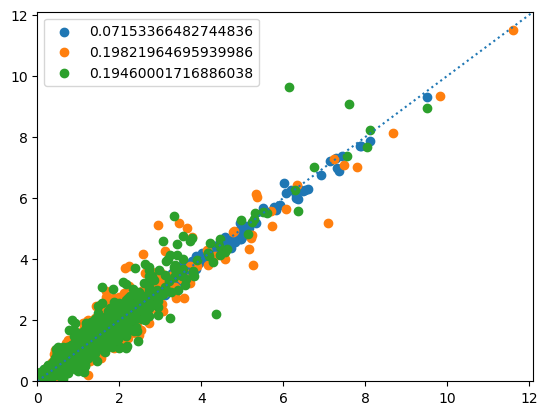

In [11]:
for dt in dtypes:
    plt.scatter(predictions[dt]/100, infidelities[dt]/100, label=np.mean(abs_errors[dt]))

max_infidelity = np.max([np.max(infidelities[dt]) for dt in dtypes]) / 100
max_pred = np.max([np.max(predictions[dt]) for dt in dtypes]) / 100
max_val = max(max_infidelity, max_pred)
                        
plt.plot([0,max_val+.5],[0,max_val+.5], ':')
plt.xlim(0,max_val+.5)
plt.ylim(0,max_val+.5)
plt.legend()

# Mirror circuit predictions

In the next few cells, we will re-create the model trained on the {exp_num} dataset using its saved weights. Then we make and save the model's predictions on the dataset's mirror circuits.

In [12]:
alphas = {'train': 1, 'validate': .75, 'test': .4}

exp_path = f'./experiment_{exp_num}/'
sim_path = exp_path + '/simulation_results/'
proc_path = exp_path + '/processed_inputs_and_outputs/'

model_path = exp_path + '/models/'
history_path = exp_path + '/training_histories/'
pred_path = exp_path + '/predictions/'

with open(exp_path+'/meta.json', 'r') as f:
    meta = json.load(f)

num_qubits = meta['num_qubits']
max_error_weight = meta['max_error_weight']
num_hops = meta['num_hops']
num_channels = meta['num_channels']
if meta['geometry'] == 'ring':
    adj_matrix = ml.newtools.ring_adj_matrix(num_qubits)
    laplace = ml.newtools.laplace_from_qubit_graph(adj_matrix)
else:
    print(f'You have not implemented the {geometry} geometry.')

error_gens = ml.newtools.up_to_weight_k_error_gens_from_qubit_graph(max_error_weight, num_qubits, laplace, num_hops)

In [13]:
# Load up the model

layer_snipper = ml.newneuralnets.layer_snipper_from_qubit_graph
layer_snipper_args = [num_qubits, num_channels, laplace, num_hops]

optimizer = keras.optimizers.Adam(learning_rate=1e-3)

circuit_dense1 = ml.newneuralnets.CircuitErrorVec(num_qubits, num_channels, error_gens, layer_snipper,
                                                layer_snipper_args)

# circuit_dense1.compile(optimizer, loss=keras.losses.MeanSquaredError())

circuit_dense1.load_weights(model_path+'custom_neural_network/')

In [14]:
o_circuits = np.load(proc_path + '/processed_mirrored_circuits.npz')['circuits']
o_infidelities = np.load(proc_path + '/processed_mirrored_infidelities.npz')['infidelities']

In [15]:
o_predictions = circuit_dense1.predict(o_circuits)
o_abs_errors = np.abs(o_predictions/100-o_infidelities/100)

24/24 [==============================] - 44s 74ms/step


In [16]:
np.savez_compressed(pred_path + '/processed_custom_neural_net_mirrored_predictions.npz', predictions = o_predictions)

Quick visualization of the model's out-of-distribution performance on mirror circuits.

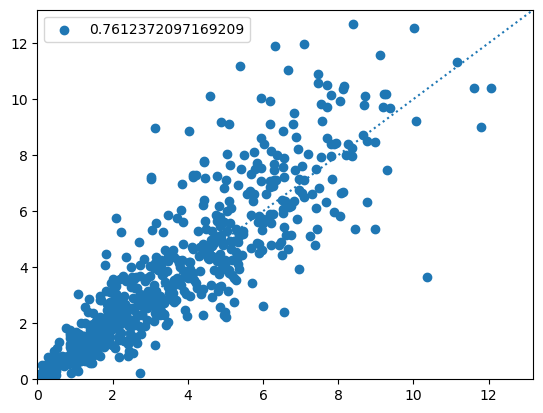

In [17]:
plt.scatter(o_predictions/100, o_infidelities/100, label=np.mean(o_abs_errors))

max_infidelity = np.max(o_infidelities) / 100
max_pred = np.max(o_predictions) / 100
max_val = max(max_infidelity, max_pred)
                        
plt.plot([0,max_val+.5],[0,max_val+.5], ':')
plt.xlim(0,max_val+.5)
plt.ylim(0,max_val+.5)
plt.legend()